In [25]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

In [26]:
# FOM discretization
import gdown
gdown.download(id = "1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO", output = "leak_mesh.xml")
mesh = fe.loadmesh("leak_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

In [27]:
# Dataset (parameters and pressure fields)
gdown.download(id = "1eEtqZPjLe3xPed15ckTAGNBYDQ8px8aJ", output = "leak_data.npz")
clc()
dataset = np.load("leak_data.npz")
mu, pressure = dataset['mu'], dataset['u']

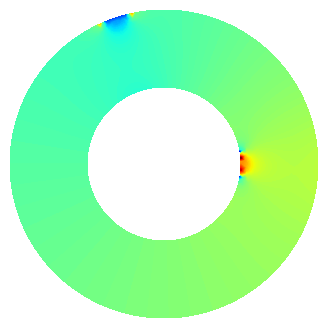

In [28]:
# Plot of the first simulation in the dataset
plt.figure(figsize = (4, 4))
fe.plot(pressure[0], Vh)

In [29]:
# Pressure measurements for the inverse problem
gdown.download(id = "1STu-gV96oB4Gqtv-kf9aenXODqJ7kdIq", output = "sensor_measurements.npz")
clc()

measurements = np.load("sensor_measurements.npz")
sensors_location, sensors_values = measurements['sensor_indices'], measurements['pressure_measurements']

In [30]:
possible_values = pressure[0, sensors_location] # sensor values expected if the pressure field was the one in the first simulation
discrepancy = np.sum((possible_values - sensors_values)**2)
discrepancy

np.float64(0.059697524234095176)

In [31]:
mu.shape,pressure.shape
print(possible_values[0].shape)

()


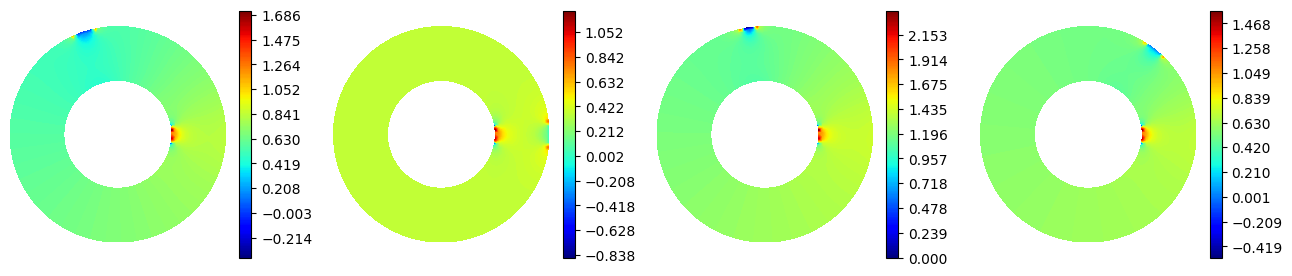

In [76]:
fe.multiplot(pressure[:4], (1, 4), Vh, colorbar=True)

In [33]:
mu,pressure=dv.tensor(dataset['mu']),dv.tensor(dataset['u'])
display(mu.shape,pressure.shape)
ndata,nh=pressure.shape
p=mu.shape[-1]
print("Trajectories:\t%d."% ndata)
print("FOM dimension:\t%d."%nh)
print("Parameters:\t%d."%p)


torch.Size([200, 3])

torch.Size([200, 3899])

Trajectories:	200.
FOM dimension:	3899.
Parameters:	3.


In [34]:
l2 = L2(Vh)
l2.cuda()
clc()
ntimes=1
ntrain = 150*ntimes

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean() #loss-function

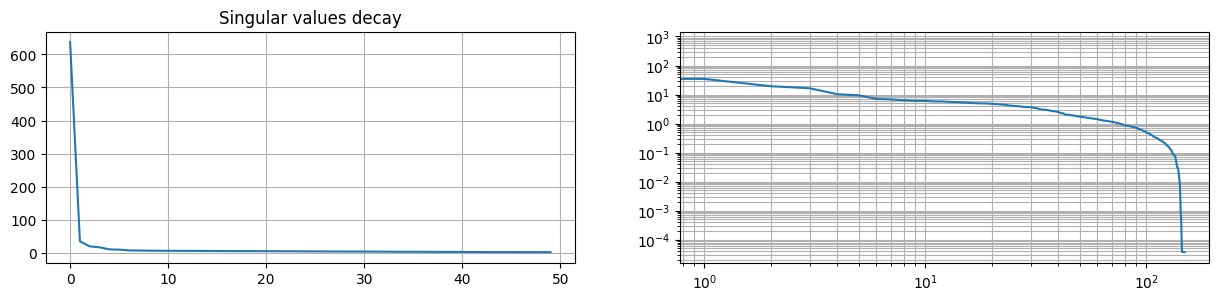

In [35]:
# Preliminary check to see if we actually need autoencoders!
from scipy.linalg import svd
import matplotlib.pyplot as plt

X, s, _ = svd(pressure[:ntrain].T.cpu().numpy(), full_matrices = False)
plt.figure(figsize = (15, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(50), s[:50])
plt.title("Singular values decay")
plt.grid()
plt.subplot(1, 2, 2)
plt.loglog(s)
plt.grid(True,which="both")
plt.show()

In [36]:
from torch.optim import Adam
rho_e=lambda x:relu(x) -10*relu(-x)
rho_d= lambda x:relu(x) -0.1*relu(-x)

Latent=7
encoder=Dense(nh,50,rho_e)+Dense(50,Latent,rho_e)
decoder=Dense(Latent,50,rho_d)+Dense(50,100,rho_d)+Dense(100,nh,activation=None)
autoencoder=DFNN(encoder+decoder)

autoencoder.He()
autoencoder.cuda()

autoencoder.train(pressure,pressure,ntrain=ntrain,  epochs=30, loss=mse(l2),
                  error=error,notation='%')

autoencoder.train(pressure,pressure,ntrain=ntrain, epochs=2000, loss=mse(l2),
                  optim=Adam, lr=1e-5, batchsize=64,
                  error=error, notation='%')




		Train	Test
Epoch 2000:	3.92%	4.04%.

>> ETA: 0.03s.

Training complete. Elapsed time: 53.94 seconds.


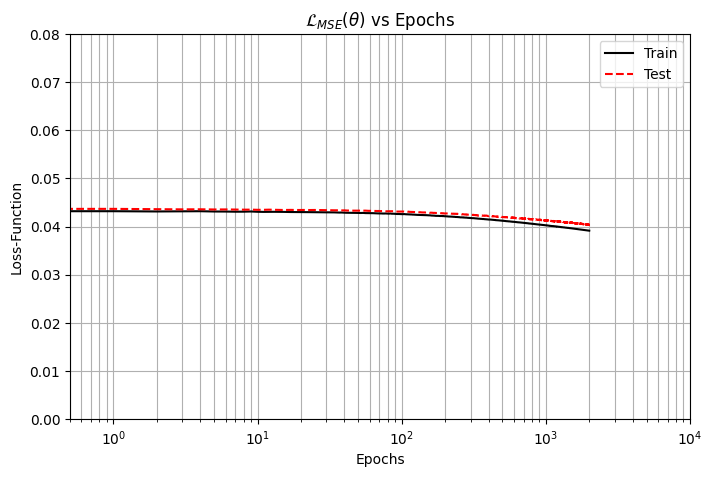

In [41]:
plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}_{MSE}(\theta)$ vs Epochs')
plt.semilogx(autoencoder.errors['Train'], '-k', label = 'Train')
plt.semilogx(autoencoder.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 10000, 0, 0.08])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [42]:
autoencoder.freeze()

In [43]:
print("Autoencoder MRE: %s"%num2p(error(pressure[ntrain:],autoencoder(pressure[ntrain:]))))

Autoencoder MRE: 4.04%


In [54]:
nu=encoder(pressure)
print(mu.shape,nu.shape)
from dlroms.dnns import Fourier
fmodes=20
phi=DFNN(Fourier(fmodes, which=[-1]) + Dense(p+2*fmodes, 500, gelu) + Dense(500, Latent, activation = None))

phi.He()
phi.cuda()
phi.train(mu,nu,ntrain=ntrain, epochs=40,loss=mse(euclidean))
phi.freeze()

		Train		Test
Epoch 40:	5.75e+03	8.36e+03.

>> ETA: 0.87s.

Training complete. Elapsed time: 34.87 seconds.


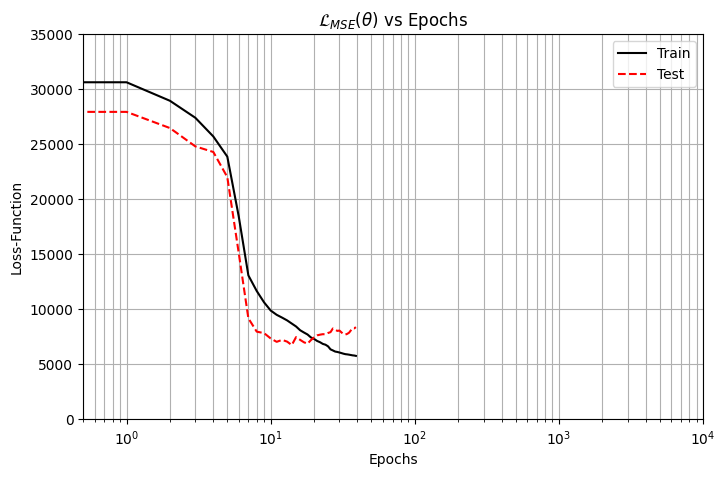

In [65]:
plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}_{MSE}(\theta)$ vs Epochs')
plt.semilogx(phi.errors['Train'], '-k', label = 'Train')
plt.semilogx(phi.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 10000, 0, 3.5e+4])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [56]:
dlrom = lambda mt: decoder(phi(mt))
num2p(error(pressure[ntrain:], dlrom(mu[ntrain:])))

'10.88%'

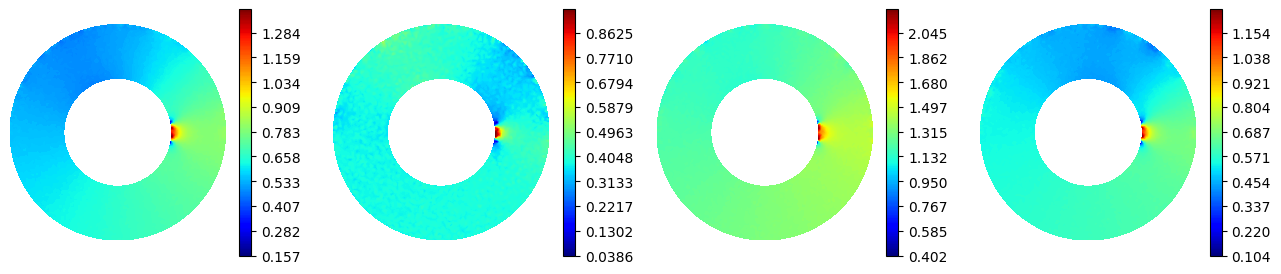

In [75]:
fe.multiplot(dlrom(mu[0:4]),(1,4),Vh,colorbar=True)

In [66]:
from time import perf_counter
mu0 = dv.tensor([5.8e-01, 7.2e-01, 6.1e-01])


t0 = perf_counter()
uROM = dlrom(mu)
t1 = perf_counter()
print("DL-ROM simulation time: %.3fs." % (t1-t0))

DL-ROM simulation time: 0.008s.


In [68]:
u_sensors = uROM[:, sensors_location]
print(u_sensors.shape)

torch.Size([200, 8])


In [70]:
lsp=(np.abs((possible_values-u_sensors.cpu().numpy()))**2).sum(axis=1)
print(lsp.shape)

(200,)


0.002376486151295621
154


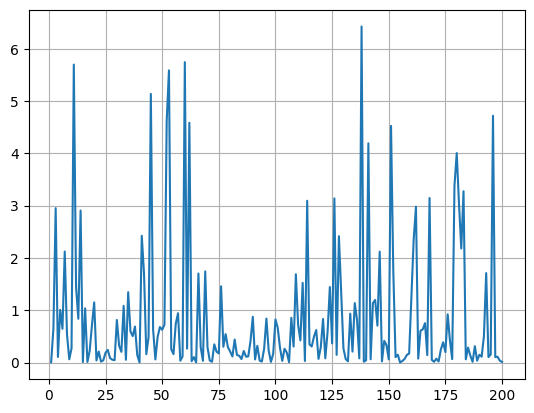

In [72]:
x=np.linspace(1,200,200)
plt.plot(x,lsp)
plt.grid()
print(np.mean(lsp[154]))
print(np.argmin(lsp))